# 2. Optimisation
use the pre-computed prediction for each sample ("sample_features.pkl") in optimisation. The pre-computed data is required.

In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange

sample_features = pd.read_pickle('sample_features.pkl')

my_systems = {
    'FaceNet':64.01,
    'r50':76.63,
    'EfficientNet':76.95,
    'ReXNet':76.29,
    'AttentionNet':74,
    'RepVGG':76.61,
    'GhostNet':77.78,
    'TF-NAS':75.86,
    'LightCNN':77.52
}

get_angle = lambda a, b: np.rad2deg(np.arccos((np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b) + 1e-7))))


In [2]:
sample_features = sample_features[~sample_features.index.duplicated(keep='first')]

In [3]:
P_ = {}

for k, v in my_systems.items():
    
    P_[k] = {}
    
    for m1, m1_, m2, _ in pd.read_csv('test_suite/glasses_7.csv').values:


        i1 = sample_features[k][m1]
        i2 = sample_features[k][m2]
        i1_ = sample_features[k][m1_]

        y_pred = get_angle(i1, i2) < v
        y_pred_ = get_angle(i1_, i2) < v

        P_[k][m1, m1_, m2] = (y_pred == y_pred_)

df = pd.DataFrame(P_)

In [4]:
len(sample_features)

143732

In [5]:
from scipy import stats
import matplotlib.pyplot as plt

def show_crr(silver, bronze, *groups):

    ma = ['<', 'P', 'd']
    cl = ['#ff0000', '#0000ff', '#00ff00', '#000000']
    
    fig=plt.figure(figsize=(4,4), dpi= 100, facecolor='w', edgecolor='k')

    for i, g in enumerate(groups):
        plt.plot(g, silver[g], color=cl[i], marker=ma[i], ms=9, label=f"Group {i} silver")
        plt.plot(g, bronze[g], '-.', color=cl[i], marker=ma[i], ms=9, label=f"Group {i}: crr {stats.pearsonr(bronze[g], silver[g])[0]:.2f}")

    plt.xlabel("System ID")
    plt.ylabel("True Positive Rate")
    # plt.title(f"")
    plt.legend()
    plt.show()
    return stats.pearsonr(bronze[groups[0]], silver[groups[0]])[0]


In [6]:
known_robustness = np.array([3764.00, 2354.00, 2619.00, 2433.00, 1635.00, 2373.00, 2592.00, 2207.00, 3600.00])
known_robustness = (known_robustness - known_robustness.min())/ (known_robustness.max() - known_robustness.min())
known_robustness

array([1.        , 0.33771724, 0.46218882, 0.37482386, 0.        ,
       0.34664162, 0.44950681, 0.26867074, 0.92296853])

In [7]:
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling

from pymoo.core.population import Population



def obj_func(inputs, x):
    return - np.array(list(map(lambda b: obj_func_single(inputs, b), x)))

class MyProblem(Problem):

    def __init__(self, inputs):
        self.inputs = inputs
        super().__init__(n_var=self.inputs.shape[0], n_obj=1, n_constr=0, xl=0, xu=1, type_var=int)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = obj_func(self.inputs, x)
        # print(x.sum(1).min() - 1200)
        # out["G"] = x.sum(1) - 1200

In [8]:
indices = np.array([0, 2, 3, 4, 5, 6, 7, 8])
tuning = np.array([0, 2, 3, 4, 5])
testing = np.array([x for x in indices if x not in tuning])


In [9]:
def obj_func_single(inputs, variables):
    bronze = np.nanmean(inputs[variables.astype(bool)], 0)
    return stats.pearsonr(bronze[tuning], known_robustness[tuning])[0] + bronze[tuning].mean() * 1e-0 + bronze[tuning].std() * 1e-0 - variables.sum() / len(variables) #- max(1200, len(variables))  * 1e-2

algorithm = GA(
    pop_size=280,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True)


releases = []

for r in range(2):
    df_ = - df.iloc[r::2,]
    res = minimize(
        MyProblem(df_.values.astype(int)),
        algorithm,
        ('n_gen', 100),
        verbose=True)

    predicted_robustness = df_.values[res.X.astype(bool)].mean(0)
    predicted_robustness = (predicted_robustness - predicted_robustness[indices].min())/ (predicted_robustness[indices].max() - predicted_robustness[indices].min())
    break

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      280 | -5.485054E-01 | -5.860460E-01
     2 |      560 | -5.619168E-01 | -5.860460E-01
     3 |      840 | -5.697375E-01 | -5.890359E-01
     4 |     1120 | -5.770528E-01 | -5.940316E-01
     5 |     1400 | -5.844239E-01 | -6.060361E-01
     6 |     1680 | -5.911193E-01 | -6.097180E-01
     7 |     1960 | -5.974778E-01 | -6.213703E-01
     8 |     2240 | -6.039882E-01 | -6.276752E-01
     9 |     2520 | -6.101497E-01 | -6.300050E-01
    10 |     2800 | -6.166355E-01 | -6.347070E-01
    11 |     3080 | -6.229123E-01 | -6.407456E-01
    12 |     3360 | -6.287555E-01 | -6.482784E-01
    13 |     3640 | -6.346797E-01 | -6.580046E-01
    14 |     3920 | -6.409699E-01 | -6.580046E-01
    15 |     4200 | -6.463866E-01 | -6.604266E-01
    16 |     4480 | -6.516025E-01 | -6.654914E-01
    17 |     4760 | -6.561991E-01 | -6.690055E-01
    18 |     5040 | -6.604574E-01 | -6.744583E-01
    19 |     5320 | -6.645798E-01 | -6.777784E-01


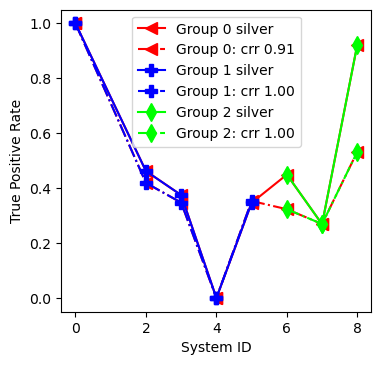

[1.    5.683 0.419 0.347 0.    0.353 0.323 0.269 0.533]
1006


In [10]:
crr = show_crr(known_robustness, predicted_robustness, indices, tuning, testing)
print(np.round(predicted_robustness, 3))
print(res.X.sum())
releases.append(list(df_[res.X].index))
